In [1]:
!pip install selenium beautifulsoup4 webdriver-manager

In [5]:
import time
import csv
import re
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

# ————— CONFIG —————
IPHONE_MODELS = [
    "iPhone 12", "iPhone 12 Pro", "iPhone 12 Pro Max",
    "iPhone 13", "iPhone 13 Pro", "iPhone 13 Pro Max",
    "iPhone 14", "iPhone 14 Pro", "iPhone 14 Pro Max",
    "iPhone 15", "iPhone 15 Pro", "iPhone 15 Pro Max"
]
SAMSUNG_MODELS = [
    "Galaxy S20", "Galaxy S20+", "Galaxy S20 Ultra",
    "Galaxy S21", "Galaxy S21+", "Galaxy S21 Ultra",
    "Galaxy S22", "Galaxy S22+", "Galaxy S22 Ultra",
    "Galaxy S23", "Galaxy S23+", "Galaxy S23 Ultra"
]
PAGES       = 10
MAX_RETRIES = 3
UA_STRING   = (
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
    "AppleWebKit/537.36 (KHTML, like Gecko) "
    "Chrome/113.0.0.0 Safari/537.36"
)
sold_pattern = re.compile(r"^Sold\s+", re.IGNORECASE)

def build_url(query, page):
    return (
        "https://www.ebay.com/sch/i.html"
        f"?_nkw={query.replace(' ', '+')}"
        "&_sacat=0"
        "&LH_Complete=1"
        f"&_pgn={page}"
    )

def make_patterns(model):
    ml = model.lower()
    plus_variant = '+' in model or 'plus' in ml
    raw = ml
    if plus_variant:
        raw = raw.replace('+','').replace('plus','')
    raw = raw.strip()
    base = re.escape(raw)
    if plus_variant:
        inc = re.compile(rf"\b{base}(?:\+| plus)+\b", re.IGNORECASE)
    else:
        inc = re.compile(rf"\b{base}\b", re.IGNORECASE)
    exclude_keys = ["pro","max","mini","plus","ultra"]
    excl = []
    for key in exclude_keys:
        if key in ml: 
            continue
        if key == "plus" and plus_variant:
            continue
        excl.append(key)
    ex_pat = re.compile(r"\b("+"|".join(excl)+r")\b", re.IGNORECASE) if excl else re.compile(r"^$")
    return inc, ex_pat

def scrape_listings(models, output_csv):
    print(f"\n=== Starting scrape for {len(models)} models, will write to '{output_csv}' ===")
    opts = Options()
    opts.add_argument("--headless")
    opts.add_argument(f"user-agent={UA_STRING}")
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=opts)

    all_data = {}
    for model in models:
        print(f"\n-- Scraping model: {model}")
        inc_pat, excl_pat = make_patterns(model)
        listings = []
        for pg in range(1, PAGES+1):
            url = build_url(model, pg)
            print(f"   Page {pg}/{PAGES} → {url}")
            # polite delay
            time.sleep(1 + (pg % 3))
            driver.get(url)

            soup = BeautifulSoup(driver.page_source, "html.parser")
            items = soup.select("li.s-item")
            retries = 0
            while not items and retries < MAX_RETRIES:
                backoff = 2**retries
                print(f"     [!] no items found, retry {retries+1} in {backoff}s…")
                time.sleep(backoff)
                driver.get(url)
                soup = BeautifulSoup(driver.page_source, "html.parser")
                items = soup.select("li.s-item")
                retries += 1

            print(f"     Found {len(items)} total .s-item elements")
            page_hits = 0
            for itm in items:
                sold = next((s for s in itm.stripped_strings if sold_pattern.match(s)), None)
                if not sold: 
                    continue
                title_el = itm.find(class_="s-item__title")
                title = title_el.get_text(strip=True) if title_el else ""
                if not inc_pat.search(title) or excl_pat.search(title):
                    continue
                price_el = itm.find("span", class_="s-item__price")
                price = price_el.get_text(strip=True) if price_el else ""
                listings.append((title, price))
                page_hits += 1
            print(f"     → Collected {page_hits} listings this page (total {len(listings)})")
        all_data[model] = listings

    driver.quit()

    # write CSV
    print(f"\nWriting CSV '{output_csv}' with {len(models)} models…")
    header = []
    for m in models:
        header += [f"{m} Title", f"{m} Price"]
    max_len = max((len(v) for v in all_data.values()), default=0)

    with open(output_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        for i in range(max_len):
            row = []
            for model in models:
                vals = all_data[model]
                if i < len(vals):
                    row += [vals[i][0], vals[i][1]]
                else:
                    row += ["", ""]
            writer.writerow(row)
    print(f"Done writing '{output_csv}', {max_len} rows.")

if __name__ == "__main__":
    scrape_listings(IPHONE_MODELS, "all_iphones_sold_listings.csv")
    scrape_listings(SAMSUNG_MODELS, "all_samsungs_sold_listings.csv")



=== Starting scrape for 12 models, will write to 'all_iphones_sold_listings.csv' ===

-- Scraping model: iPhone 12
   Page 1/10 → https://www.ebay.com/sch/i.html?_nkw=iPhone+12&_sacat=0&LH_Complete=1&_pgn=1
     [!] no items found, retry 1 in 1s…
     Found 62 total .s-item elements
     → Collected 13 listings this page (total 13)
   Page 2/10 → https://www.ebay.com/sch/i.html?_nkw=iPhone+12&_sacat=0&LH_Complete=1&_pgn=2
     Found 62 total .s-item elements
     → Collected 23 listings this page (total 36)
   Page 3/10 → https://www.ebay.com/sch/i.html?_nkw=iPhone+12&_sacat=0&LH_Complete=1&_pgn=3
     Found 62 total .s-item elements
     → Collected 18 listings this page (total 54)
   Page 4/10 → https://www.ebay.com/sch/i.html?_nkw=iPhone+12&_sacat=0&LH_Complete=1&_pgn=4
     [!] no items found, retry 1 in 1s…
     Found 62 total .s-item elements
     → Collected 26 listings this page (total 80)
   Page 5/10 → https://www.ebay.com/sch/i.html?_nkw=iPhone+12&_sacat=0&LH_Complete=1&_pg


iPhone Depreciation Summary:


,model,sales_count,avg_depr_pct,avg_annual_depr
0,iPhone 12,225,75.614780,15.122956
1,iPhone 12 Pro,91,72.562013,14.512403
2,iPhone 12 Pro Max,381,72.341260,14.468252
3,iPhone 13,162,67.851852,16.962963
4,iPhone 13 Pro,152,64.503688,16.125922
5,iPhone 13 Pro Max,318,62.565382,15.641346
6,iPhone 14,144,62.607965,20.869322
7,iPhone 14 Pro,90,55.315960,18.438653
8,iPhone 14 Pro Max,497,54.272294,18.090765
9,iPhone 15,159,44.614243,22.307121



Galaxy S Depreciation Summary:


,model,sales_count,avg_depr_pct,avg_annual_depr
0,Galaxy S20,297,88.521741,17.704348
1,Galaxy S20 Ultra,314,85.718384,17.143677
2,Galaxy S20+,84,85.056356,17.011271
3,Galaxy S21,260,83.174035,20.793509
4,Galaxy S21 Ultra,178,81.833438,20.458359
5,Galaxy S21+,40,81.938388,20.484597
6,Galaxy S22,149,76.017564,25.339188
7,Galaxy S22 Ultra,335,74.309922,24.769974
8,Galaxy S22+,49,76.461911,25.487304
9,Galaxy S23,139,65.717651,32.858825


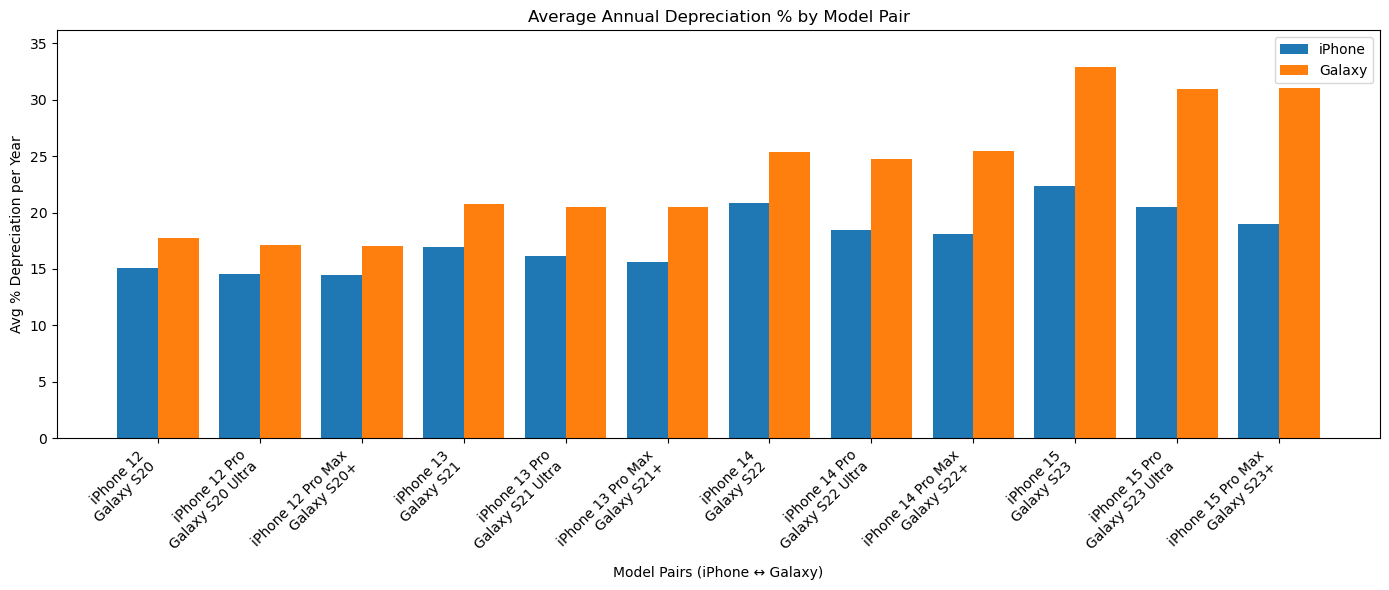

In [3]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the scraped CSVs
iphone_df  = pd.read_csv("all_iphones_sold_listings.csv")
samsung_df = pd.read_csv("all_samsungs_sold_listings.csv")

# Helper function to clean & melt wide to long
def prepare(df):
    price_re = re.compile(r".*?\$?([\d,]+(?:\.\d+)?)")
    rows = []
    for col in df.columns:
        if col.endswith(" Title"):
            model = col[:-6]
            price_col = model + " Price"
            for title, raw in zip(df[col], df[price_col]):
                if not isinstance(title, str) or not title.strip():
                    continue
                m = price_re.match(str(raw))
                if not m:
                    continue
                p = float(m.group(1).replace(",", ""))
                if p < 10:   # drop under $10
                    continue
                rows.append({"model": model, "price": p})
    return pd.DataFrame(rows)

iphone_long  = prepare(iphone_df)
samsung_long = prepare(samsung_df)

# Launch data for depreciation
launch_data = [
    ("iPhone 12",        2020,  799),
    ("iPhone 12 Pro",    2020,  999),
    ("iPhone 12 Pro Max",2020, 1099),
    ("iPhone 13",        2021,  799),
    ("iPhone 13 Pro",    2021,  999),
    ("iPhone 13 Pro Max",2021, 1099),
    ("iPhone 14",        2022,  799),
    ("iPhone 14 Pro",    2022,  999),
    ("iPhone 14 Pro Max",2022, 1099),
    ("iPhone 15",        2023,  799),
    ("iPhone 15 Pro",    2023,  999),
    ("iPhone 15 Pro Max",2023, 1099),
    ("Galaxy S20",       2020,  999),
    ("Galaxy S20+",      2020, 1199),
    ("Galaxy S20 Ultra", 2020, 1399),
    ("Galaxy S21",       2021,  799),
    ("Galaxy S21+",      2021,  999),
    ("Galaxy S21 Ultra", 2021, 1199),
    ("Galaxy S22",       2022,  799),
    ("Galaxy S22+",      2022,  999),
    ("Galaxy S22 Ultra", 2022, 1199),
    ("Galaxy S23",       2023,  799),
    ("Galaxy S23+",      2023,  999),
    ("Galaxy S23 Ultra", 2023, 1199),
]
launch_df = pd.DataFrame(launch_data, columns=["model","launch_year","launch_price"])

# Enrich: compute age, depreciation %, and annual depreciation
def enrich(df):
    df = df.merge(launch_df, on="model", how="left")
    df["age_years"]       = 2025 - df["launch_year"]
    df["depr_pct"]        = (df["launch_price"] - df["price"]) / df["launch_price"] * 100
    df["annual_depr_pct"] = df["depr_pct"] / df["age_years"]
    return df

iphone_dep  = enrich(iphone_long)
samsung_dep = enrich(samsung_long)

# Summary tables
def summarise(df, name):
    summ = df.groupby("model").agg(
        sales_count       = ("price",          "count"),
        avg_depr_pct      = ("depr_pct",       "mean"),
        avg_annual_depr   = ("annual_depr_pct","mean")
    ).reset_index()
    print(f"\n{name} Depreciation Summary:")
    display(summ)
    return summ

iphone_sum  = summarise(iphone_dep,  "iPhone")
samsung_sum = summarise(samsung_dep, "Galaxy S")

# Merged bar chart: avg annual % depreciation
IP              = iphone_sum["model"].tolist()
GAL             = samsung_sum["model"].tolist()
iphone_vals     = iphone_sum["avg_annual_depr"].tolist()
galaxy_vals     = samsung_sum["avg_annual_depr"].tolist()

x    = np.arange(len(IP))
w    = 0.4

plt.figure(figsize=(14,6))
plt.bar(x-w/2, iphone_vals, w, label="iPhone", color="#1f77b4")
plt.bar(x+w/2, galaxy_vals, w, label="Galaxy", color="#ff7f0e")

plt.xticks(x, [f"{i}\n{g}" for i,g in zip(IP,GAL)], rotation=45, ha="right")
plt.ylim(0, max(max(iphone_vals), max(galaxy_vals)) * 1.1)
plt.title("Average Annual Depreciation % by Model Pair")
plt.xlabel("Model Pairs (iPhone ↔ Galaxy)")
plt.ylabel("Avg % Depreciation per Year")
plt.legend()
plt.tight_layout()
plt.show()


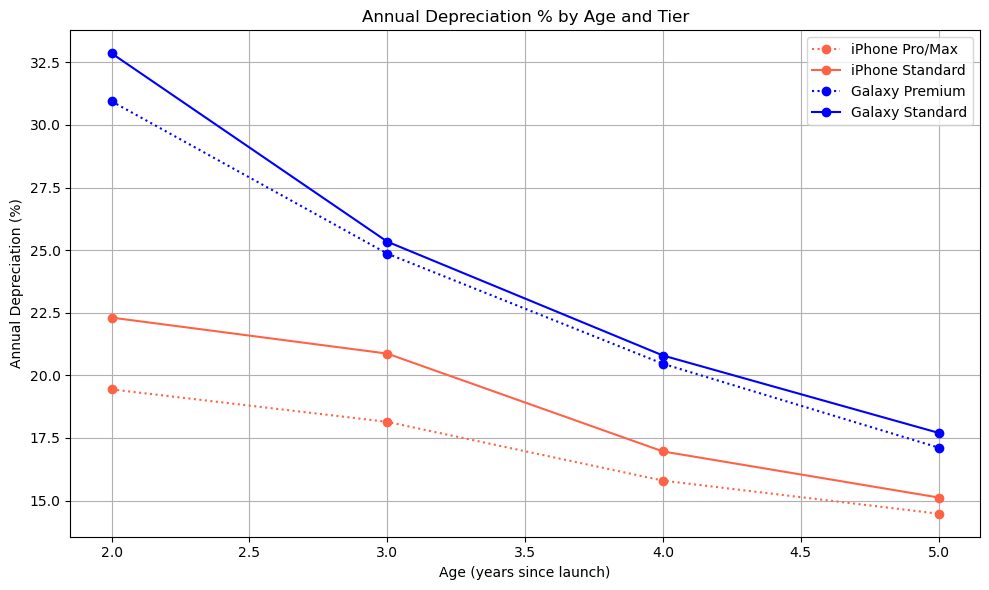

In [5]:

# 1. Separate premium vs non‑premium
premium_i = iphone_dep[iphone_dep['model'].str.contains('Pro')]
nonpremium_i = iphone_dep[~iphone_dep['model'].str.contains('Pro')]

premium_g = samsung_dep[samsung_dep['model'].str.contains(r'\+|Ultra', regex=True)]
nonpremium_g = samsung_dep[~samsung_dep['model'].str.contains(r'\+|Ultra', regex=True)]

# 2. Compute mean annual depreciation % by age
iph_prem_trend = premium_i.groupby('age_years')['annual_depr_pct'].mean()
iph_non_trend  = nonpremium_i.groupby('age_years')['annual_depr_pct'].mean()
gal_prem_trend = premium_g.groupby('age_years')['annual_depr_pct'].mean()
gal_non_trend  = nonpremium_g.groupby('age_years')['annual_depr_pct'].mean()

# 3. Plot the four lines
plt.figure(figsize=(10,6))
plt.plot(iph_prem_trend.index, iph_prem_trend.values,
         linestyle=':', marker='o', color='tomato', label='iPhone Pro/Max')
plt.plot(iph_non_trend.index, iph_non_trend.values,
         linestyle='-', marker='o', color='tomato', label='iPhone Standard')
plt.plot(gal_prem_trend.index, gal_prem_trend.values,
         linestyle=':', marker='o', color='blue', label='Galaxy Premium')
plt.plot(gal_non_trend.index, gal_non_trend.values,
         linestyle='-', marker='o', color='blue', label='Galaxy Standard')

plt.title('Annual Depreciation % by Age and Tier')
plt.xlabel('Age (years since launch)')
plt.ylabel('Annual Depreciation (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
